# Prostate cancer Prediction 
# Status as the Response Variable

# Load necessary libraries and data


In [452]:
# Load necessary libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, accuracy_score
import statsmodels.api as sm
import statsmodels.formula.api as smf
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score
from scipy import stats
from sklearn.model_selection import cross_val_score, KFold
from sklearn.model_selection import cross_val_predict
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix
import statsmodels.api as sm
from sklearn.metrics import roc_auc_score, roc_curve




In [453]:
# Load the data
data = pd.read_excel("PCA_Data.xlsx")

# Convert Statuscode to categorical
data['Statuscode'] = data['Statuscode'].astype('category')


# Convert Statuscode to numeric
data['Statuscode'] = pd.to_numeric(data['Statuscode'], errors='coerce')

# Check for NaN values
print(data['Statuscode'].isnull().sum())  # Handle NaNs if any

# Drop NaN rows if necessary
data = data.dropna(subset=['Statuscode'])

0


## Remove Outliers

In [454]:
# Function to remove outliers
def remove_outliers(x):
    Q1 = np.percentile(x, 25)
    Q3 = np.percentile(x, 75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return np.where((x >= lower_bound) & (x <= upper_bound), x, np.nan)

# Remove outliers for each variable
for col in ['Exon 9', 'Exon 4a', 'Exon 4b', 'baselinePSA']:
    data[col] = remove_outliers(data[col])

# Drop rows with missing values
data = data.dropna(subset=['Exon 9', 'Exon 4a', 'baselinePSA'])

## Boxplots of each predictor variable with Statuscode


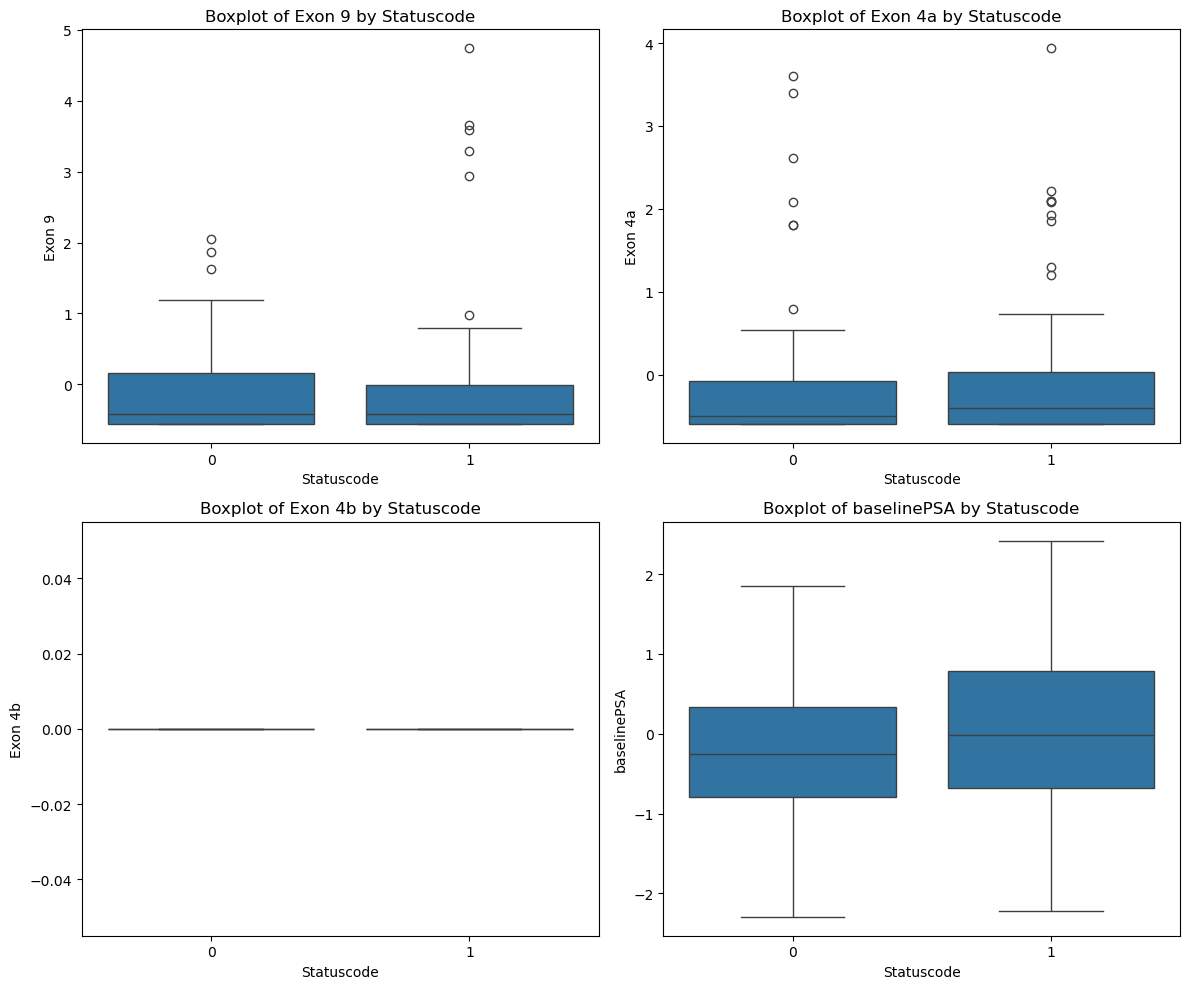

In [455]:
# Normalize the predictor variables
scaler = StandardScaler()
data[['Exon 9', 'Exon 4a', 'Exon 4b', 'baselinePSA']] = scaler.fit_transform(data[['Exon 9', 'Exon 4a', 'Exon 4b', 'baselinePSA']])

# Boxplots of each predictor variable with Statuscode
fig, axes = plt.subplots(2, 2, figsize=(12, 10))
sns.boxplot(x='Statuscode', y='Exon 9', data=data, ax=axes[0, 0])
axes[0, 0].set_title("Boxplot of Exon 9 by Statuscode")
sns.boxplot(x='Statuscode', y='Exon 4a', data=data, ax=axes[0, 1])
axes[0, 1].set_title("Boxplot of Exon 4a by Statuscode")
sns.boxplot(x='Statuscode', y='Exon 4b', data=data, ax=axes[1, 0])
axes[1, 0].set_title("Boxplot of Exon 4b by Statuscode")
sns.boxplot(x='Statuscode', y='baselinePSA', data=data, ax=axes[1, 1])
axes[1, 1].set_title("Boxplot of baselinePSA by Statuscode")
plt.tight_layout()
plt.show()


## Correlation Matrix for Predictor Variables


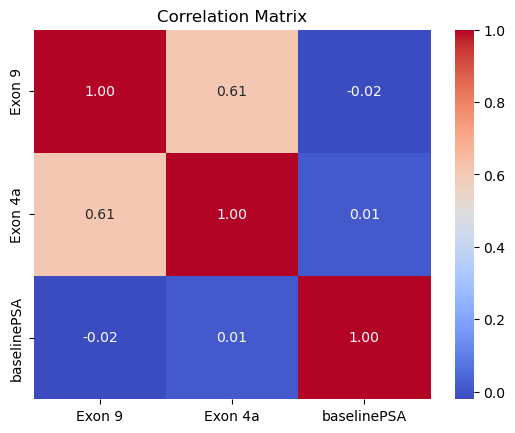

In [456]:
corr_matrix = data[['Exon 9', 'Exon 4a', 'baselinePSA']].corr()
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", fmt='.2f')
plt.title('Correlation Matrix')
plt.show()

## Single Logistic Regression for each predictor


In [457]:
data.rename(columns={'Exon 9': 'Exon9'}, inplace=True)
data.rename(columns={'Exon 4a': 'Exon4a'}, inplace=True)
data.rename(columns={'Exon 4b': 'Exon4b'}, inplace=True)



In [458]:
# Logistic regression for Exon 9
model_exon9 = smf.logit(formula='Statuscode ~ Exon9', data=data).fit()
print(model_exon9.summary())

Optimization terminated successfully.
         Current function value: 0.689707
         Iterations 4
                           Logit Regression Results                           
Dep. Variable:             Statuscode   No. Observations:                  108
Model:                          Logit   Df Residuals:                      106
Method:                           MLE   Df Model:                            1
Date:                Mon, 21 Oct 2024   Pseudo R-squ.:                0.003977
Time:                        17:49:15   Log-Likelihood:                -74.488
converged:                       True   LL-Null:                       -74.786
Covariance Type:            nonrobust   LLR p-value:                    0.4405
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.0753      0.193      0.390      0.697      -0.303       0.454
Exon9          0.1514      0.

In [459]:
# Logistic regression for Exon 4a
model_exon4a = smf.logit(formula='Statuscode ~ Exon4a', data=data).fit()
print(model_exon4a.summary())

Optimization terminated successfully.
         Current function value: 0.691486
         Iterations 4
                           Logit Regression Results                           
Dep. Variable:             Statuscode   No. Observations:                  108
Model:                          Logit   Df Residuals:                      106
Method:                           MLE   Df Model:                            1
Date:                Mon, 21 Oct 2024   Pseudo R-squ.:                0.001409
Time:                        17:49:15   Log-Likelihood:                -74.680
converged:                       True   LL-Null:                       -74.786
Covariance Type:            nonrobust   LLR p-value:                    0.6462
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.0744      0.193      0.386      0.700      -0.303       0.452
Exon4a         0.0889      0.

In [460]:
# Logistic regression for baselinePSA
model_psa = smf.logit(formula='Statuscode ~ baselinePSA', data=data).fit()
print(model_psa.summary())

Optimization terminated successfully.
         Current function value: 0.672654
         Iterations 4
                           Logit Regression Results                           
Dep. Variable:             Statuscode   No. Observations:                  108
Model:                          Logit   Df Residuals:                      106
Method:                           MLE   Df Model:                            1
Date:                Mon, 21 Oct 2024   Pseudo R-squ.:                 0.02860
Time:                        17:49:15   Log-Likelihood:                -72.647
converged:                       True   LL-Null:                       -74.786
Covariance Type:            nonrobust   LLR p-value:                   0.03860
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept       0.0793      0.197      0.404      0.687      -0.306       0.465
baselinePSA     0.4099    

## Multiple Logistic Regression for all combinations


In [461]:
# baselinePSA + Exon 9
model_psa_exon9 = smf.logit(formula='Statuscode ~ baselinePSA + Exon9', data=data).fit()
print(model_psa_exon9.summary())


Optimization terminated successfully.
         Current function value: 0.669552
         Iterations 4
                           Logit Regression Results                           
Dep. Variable:             Statuscode   No. Observations:                  108
Model:                          Logit   Df Residuals:                      105
Method:                           MLE   Df Model:                            2
Date:                Mon, 21 Oct 2024   Pseudo R-squ.:                 0.03308
Time:                        17:49:15   Log-Likelihood:                -72.312
converged:                       True   LL-Null:                       -74.786
Covariance Type:            nonrobust   LLR p-value:                   0.08423
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept       0.0799      0.197      0.405      0.685      -0.306       0.466
baselinePSA     0.4137    

In [462]:
# baselinePSA + Exon 4a
model_psa_exon4a = smf.logit(formula='Statuscode ~ baselinePSA + Exon4a', data=data).fit()
print(model_psa_exon4a.summary())

Optimization terminated successfully.
         Current function value: 0.671770
         Iterations 4
                           Logit Regression Results                           
Dep. Variable:             Statuscode   No. Observations:                  108
Model:                          Logit   Df Residuals:                      105
Method:                           MLE   Df Model:                            2
Date:                Mon, 21 Oct 2024   Pseudo R-squ.:                 0.02988
Time:                        17:49:15   Log-Likelihood:                -72.551
converged:                       True   LL-Null:                       -74.786
Covariance Type:            nonrobust   LLR p-value:                    0.1070
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept       0.0790      0.197      0.402      0.688      -0.307       0.465
baselinePSA     0.4089    

In [463]:
# baselinePSA + Exon 9 + Exon 4a
model_psa_exon9_exon4a = smf.logit(formula='Statuscode ~ baselinePSA + Exon9 + Exon4a', data=data).fit()
print(model_psa_exon9_exon4a.summary())

Optimization terminated successfully.
         Current function value: 0.669525
         Iterations 4
                           Logit Regression Results                           
Dep. Variable:             Statuscode   No. Observations:                  108
Model:                          Logit   Df Residuals:                      104
Method:                           MLE   Df Model:                            3
Date:                Mon, 21 Oct 2024   Pseudo R-squ.:                 0.03312
Time:                        17:49:15   Log-Likelihood:                -72.309
converged:                       True   LL-Null:                       -74.786
Covariance Type:            nonrobust   LLR p-value:                    0.1752
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept       0.0801      0.197      0.406      0.685      -0.306       0.467
baselinePSA     0.4142    

## Likelihood Test

In [464]:
# Extract log-likelihoods
logL_psa = model_psa.llf
logL_psa_exon9 = model_psa_exon9.llf
logL_psa_exon4a = model_psa_exon4a.llf
logL_psa_exon9_exon4a = model_psa_exon9_exon4a.llf

# Perform likelihood ratio tests
# 1. Compare baseline model vs. PSA + Exon 9
LRT_psa_vs_psa_exon9 = 2 * (logL_psa_exon9 - logL_psa)
df1 = model_psa_exon9.df_model - model_psa.df_model
p_value_psa_vs_psa_exon9 = stats.chi2.sf(LRT_psa_vs_psa_exon9, df1)

# 2. Compare baseline model vs. PSA + Exon 4a
LRT_psa_vs_psa_exon4a = 2 * (logL_psa_exon4a - logL_psa)
df2 = model_psa_exon4a.df_model - model_psa.df_model
p_value_psa_vs_psa_exon4a = stats.chi2.sf(LRT_psa_vs_psa_exon4a, df2)

# 3. Compare PSA + Exon 9 vs. PSA + Exon 9 + Exon 4a
LRT_psa_exon9_vs_psa_exon9_exon4a = 2 * (logL_psa_exon9_exon4a - logL_psa_exon9)
df3 = model_psa_exon9_exon4a.df_model - model_psa_exon9.df_model
p_value_psa_exon9_vs_psa_exon9_exon4a = stats.chi2.sf(LRT_psa_exon9_vs_psa_exon9_exon4a, df3)

# 4. Compare PSA + Exon 4a vs. PSA + Exon 9 + Exon 4a
LRT_psa_exon4a_vs_psa_exon9_exon4a = 2 * (logL_psa_exon9_exon4a - logL_psa_exon4a)
df4 = model_psa_exon9_exon4a.df_model - model_psa_exon4a.df_model
p_value_psa_exon4a_vs_psa_exon9_exon4a = stats.chi2.sf(LRT_psa_exon4a_vs_psa_exon9_exon4a, df4)

# Print p-values
print("P-value (PSA vs PSA + Exon 9):", p_value_psa_vs_psa_exon9)
print("P-value (PSA vs PSA + Exon 4a):", p_value_psa_vs_psa_exon4a)
print("P-value (PSA + Exon 9 vs PSA + Exon 9 + Exon 4a):", p_value_psa_exon9_vs_psa_exon9_exon4a)
print("P-value (PSA + Exon 4a vs PSA + Exon 9 + Exon 4a):", p_value_psa_exon4a_vs_psa_exon9_exon4a)

P-value (PSA vs PSA + Exon 9): 0.41309901414145744
P-value (PSA vs PSA + Exon 4a): 0.6621642845067921
P-value (PSA + Exon 9 vs PSA + Exon 9 + Exon 4a): 0.9383157986594953
P-value (PSA + Exon 4a vs PSA + Exon 9 + Exon 4a): 0.4861897847430783


All the p-values are well above the typical significance threshold of 0.05, indicating that none of the models with additional variables (Exon 4a or Exon 9) provide a statistically significant improvement over the simpler models

## Model Comparison and Evaluation


## 10 fold cross validation, Likelihood Ratio, and AUC

In [465]:
def calculate_metrics(y_true, y_pred):
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    cm = confusion_matrix(y_true, y_pred)
    # Sensitivity is the same as recall for the positive class
    sensitivity = recall
    # Specificity = TN / (TN + FP)
    tn, fp, fn, tp = cm.ravel()
    specificity = tn / (tn + fp)
    
    return accuracy, precision, recall, sensitivity, specificity

In [466]:
# Define KFold cross-validation
kf = KFold(n_splits=10, shuffle=True, random_state=42)

In [467]:
# Model 1: baselinePSA + Exon 9
X1 = data[['baselinePSA', 'Exon9']]
y = data['Statuscode']

# Train logistic regression on the full dataset for likelihood comparison
log_reg1 = LogisticRegression(max_iter=1000)
log_reg1.fit(X1, y)

# Get cross-validated predictions
y_pred_model_psa_exon9 = cross_val_predict(log_reg1, X1, y, cv=kf)

# Calculate metrics
acc1, prec1, rec1, sens1, spec1 = calculate_metrics(y, y_pred_model_psa_exon9)
print(f"Model PSA + Exon 9: Accuracy={acc1:.3f}, Precision={prec1:.3f}, Recall={rec1:.3f}, Sensitivity={sens1:.3f}, Specificity={spec1:.3f}")

# Calculate log-likelihood for Model 1
ll_full1 = np.sum(np.log(np.maximum(1e-10, log_reg1.predict_proba(X1)[:, 1])))  # Likelihood for the model



Model PSA + Exon 9: Accuracy=0.574, Precision=0.589, Recall=0.589, Sensitivity=0.589, Specificity=0.558


AUC for Model PSA + Exon 9: 0.617


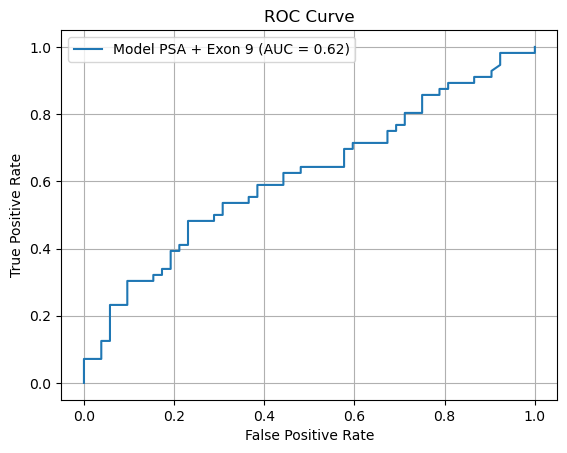

In [468]:
# Calculate AUC for Model 1
y_pred_proba_model1 = log_reg1.predict_proba(X1)[:, 1]
auc_model1 = roc_auc_score(y, y_pred_proba_model1)
print(f"AUC for Model PSA + Exon 9: {auc_model1:.3f}")

# If you want to plot the ROC curve
fpr, tpr, thresholds = roc_curve(y, y_pred_proba_model1)
plt.plot(fpr, tpr, label=f'Model PSA + Exon 9 (AUC = {auc_model1:.2f})')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.grid()
plt.show()

In [469]:
# Model 2: baselinePSA + Exon 4a
X2 = data[['baselinePSA', 'Exon4a']]

# Train logistic regression on the full dataset for likelihood comparison
log_reg2 = LogisticRegression(max_iter=1000)
log_reg2.fit(X2, y)

# Get cross-validated predictions
y_pred_model_psa_exon9_exon4a = cross_val_predict(log_reg2, X2, y, cv=kf)

# Calculate metrics
acc2, prec2, rec2, sens2, spec2 = calculate_metrics(y, y_pred_model_psa_exon9_exon4a)
print(f"Model PSA + Exon 9 + Exon 4a: Accuracy={acc2:.3f}, Precision={prec2:.3f}, Recall={rec2:.3f}, Sensitivity={sens2:.3f}, Specificity={spec2:.3f}")

# Calculate log-likelihood for Model 2
ll_full2 = np.sum(np.log(np.maximum(1e-10, log_reg2.predict_proba(X2)[:, 1])))

Model PSA + Exon 9 + Exon 4a: Accuracy=0.556, Precision=0.571, Recall=0.571, Sensitivity=0.571, Specificity=0.538


AUC for Model PSA + Exon 4a: 0.613


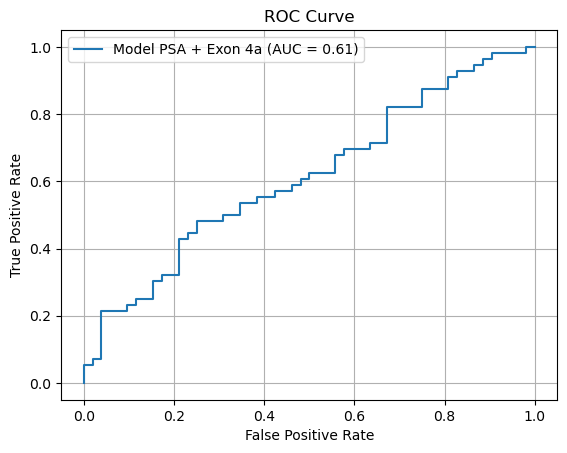

In [470]:
# Calculate AUC for Model 2
y_pred_proba_model2 = log_reg2.predict_proba(X2)[:, 1]
auc_model2 = roc_auc_score(y, y_pred_proba_model2)
print(f"AUC for Model PSA + Exon 4a: {auc_model2:.3f}")

# If you want to plot the ROC curve
fpr, tpr, thresholds = roc_curve(y, y_pred_proba_model2)
plt.plot(fpr, tpr, label=f'Model PSA + Exon 4a (AUC = {auc_model2:.2f})')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.grid()
plt.show()

In [471]:
# Model 3: baselinePSA + Exon 4a
X3 = data[['baselinePSA', 'Exon9', 'Exon4a']]

# Train logistic regression on the full dataset for likelihood comparison
log_reg3 = LogisticRegression(max_iter=1000)
log_reg3.fit(X3, y)

# Get cross-validated predictions
y_pred_model_psa_exon4a = cross_val_predict(log_reg3, X3, y, cv=kf)

# Calculate metrics
acc3, prec3, rec3, sens3, spec3 = calculate_metrics(y, y_pred_model_psa_exon4a)
print(f"Model PSA + Exon 4a: Accuracy={acc3:.3f}, Precision={prec3:.3f}, Recall={rec3:.3f}, Sensitivity={sens3:.3f}, Specificity={spec3:.3f}")

# Calculate log-likelihood for Model 3
ll_full3 = np.sum(np.log(np.maximum(1e-10, log_reg3.predict_proba(X3)[:, 1])))

Model PSA + Exon 4a: Accuracy=0.528, Precision=0.545, Recall=0.536, Sensitivity=0.536, Specificity=0.519


AUC for Model PSA + Exon 9 + Exon 4a: 0.614


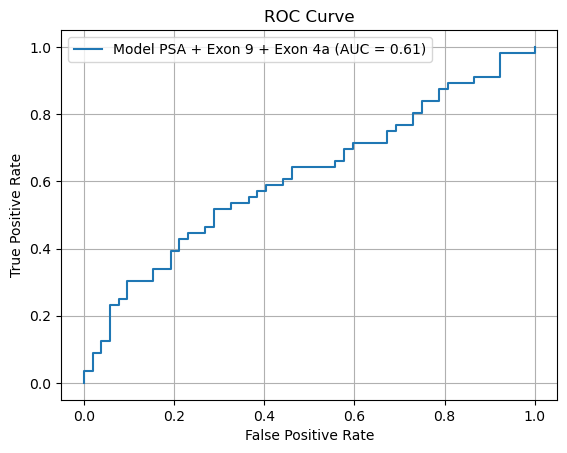

In [472]:
# Calculate AUC for Model 3
y_pred_proba_model3 = log_reg3.predict_proba(X3)[:, 1]
auc_model3 = roc_auc_score(y, y_pred_proba_model3)
print(f"AUC for Model PSA + Exon 9 + Exon 4a: {auc_model3:.3f}")

# If you want to plot the ROC curve
fpr, tpr, thresholds = roc_curve(y, y_pred_proba_model3)
plt.plot(fpr, tpr, label=f'Model PSA + Exon 9 + Exon 4a (AUC = {auc_model3:.2f})')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.grid()
plt.show()

In [473]:
# Model 4: baselinePSA only
X4 = data[['baselinePSA']]

# Train logistic regression on the full dataset for likelihood comparison
log_reg4 = LogisticRegression(max_iter=1000)
log_reg4.fit(X4, y)

# Get cross-validated predictions
y_pred_model_psa = cross_val_predict(log_reg4, X4, y, cv=kf)

# Calculate metrics
acc4, prec4, rec4, sens4, spec4 = calculate_metrics(y, y_pred_model_psa)
print(f"Model PSA Only: Accuracy={acc4:.3f}, Precision={prec4:.3f}, Recall={rec4:.3f}, Sensitivity={sens4:.3f}, Specificity={spec4:.3f}")

# Calculate log-likelihood for Model 4
ll_full4 = np.sum(np.log(np.maximum(1e-10, log_reg4.predict_proba(X4)[:, 1])))



Model PSA Only: Accuracy=0.546, Precision=0.559, Recall=0.589, Sensitivity=0.589, Specificity=0.500


AUC for Model PSA Only: 0.600


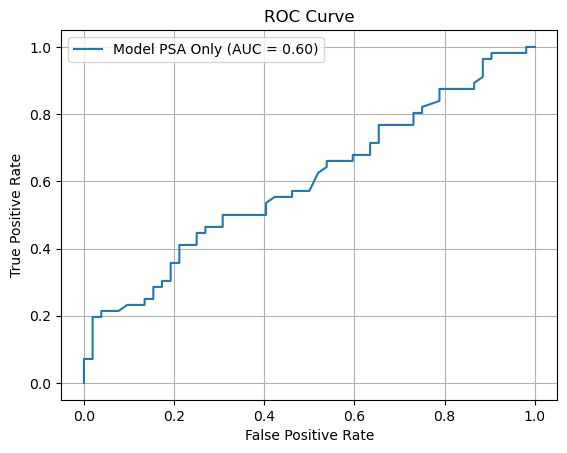

In [474]:
# Calculate AUC for Model 4
y_pred_proba_model4 = log_reg4.predict_proba(X4)[:, 1]
auc_model4 = roc_auc_score(y, y_pred_proba_model4)
print(f"AUC for Model PSA Only: {auc_model4:.3f}")

# If you want to plot the ROC curve
fpr, tpr, thresholds = roc_curve(y, y_pred_proba_model4)
plt.plot(fpr, tpr, label=f'Model PSA Only (AUC = {auc_model4:.2f})')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.grid()
plt.show()

## Likelihood Test 

In [475]:
# Perform Likelihood Ratio Tests between models
def likelihood_ratio_test(ll_full, ll_reduced, df_full, df_reduced):
    lr_stat = 2 * (ll_full - ll_reduced)
    df_diff = df_full - df_reduced
    p_value = stats.chi2.sf(lr_stat, df_diff)
    return lr_stat, p_value

# LRT: Model 3 (PSA + Exon 9 + Exon 4a) vs Model 1 (PSA + Exon 9)
lr_stat_12, p_value_12 = likelihood_ratio_test(ll_full2, ll_full1, X2.shape[1], X1.shape[1])
print(f"LRT for Model PSA + Exon 9 + Exon 4a vs PSA + Exon 9: LR Stat={lr_stat_12:.3f}, p-value={p_value_12:.3f}")

# LRT: Model 2 (PSA + Exon 4a) vs Model 4 (PSA only)
lr_stat_34, p_value_34 = likelihood_ratio_test(ll_full3, ll_full4, X3.shape[1], X4.shape[1])
print(f"LRT for Model PSA + Exon 4a vs PSA Only: LR Stat={lr_stat_34:.3f}, p-value={p_value_34:.3f}")

# LRT: Model 3 (PSA + Exon 9 + Exon 4a) vs Model 2 (PSA + Exon 4a)
lr_stat_23, p_value_23 = likelihood_ratio_test(ll_full2, ll_full3, X2.shape[1], X3.shape[1])
print(f"LRT for Model PSA + Exon 9 + Exon 4a vs PSA + Exon 4a: LR Stat={lr_stat_23:.3f}, p-value={p_value_23:.3f}")

# LRT: Model 1 (PSA + Exon 9) vs Model 4 (PSA only)
lr_stat_14, p_value_14 = likelihood_ratio_test(ll_full1, ll_full4, X1.shape[1], X4.shape[1])
print(f"LRT for Model PSA + Exon 9 vs PSA Only: LR Stat={lr_stat_14:.3f}, p-value={p_value_14:.3f}")

LRT for Model PSA + Exon 9 + Exon 4a vs PSA + Exon 9: LR Stat=0.363, p-value=nan
LRT for Model PSA + Exon 4a vs PSA Only: LR Stat=-0.587, p-value=1.000
LRT for Model PSA + Exon 9 + Exon 4a vs PSA + Exon 4a: LR Stat=0.372, p-value=nan
LRT for Model PSA + Exon 9 vs PSA Only: LR Stat=-0.578, p-value=1.000


# Prostate cancer Prediction 
# Gleason Score and Risk as the Response Variable

In [476]:
data['Gleason'].replace('N/A', 0, inplace=True)

# Convert Gleason Risk to binary: 1 for High, 0 for Low
data['GleasonRiskBinary'] = data['Gleason Risk Code'].astype('category')

data['GleasonCodes'] = np.where(data['Gleason'] == 0, 0, 
                                 np.where(data['Gleason'] == 6, 1, 
                                          np.where(data['Gleason'] >= 7, 2, 0)))

/var/folders/jj/v8sb93px4t91q34p4v5rc6780000gn/T/ipykernel_5448/3367740841.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  data['Gleason'].replace('N/A', 0, inplace=True)


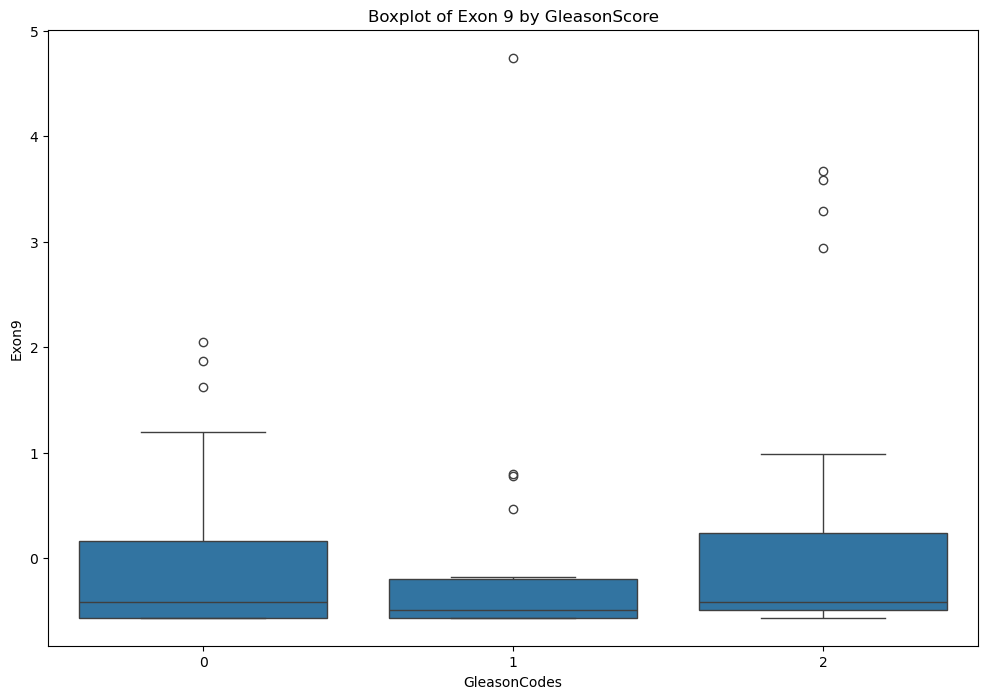

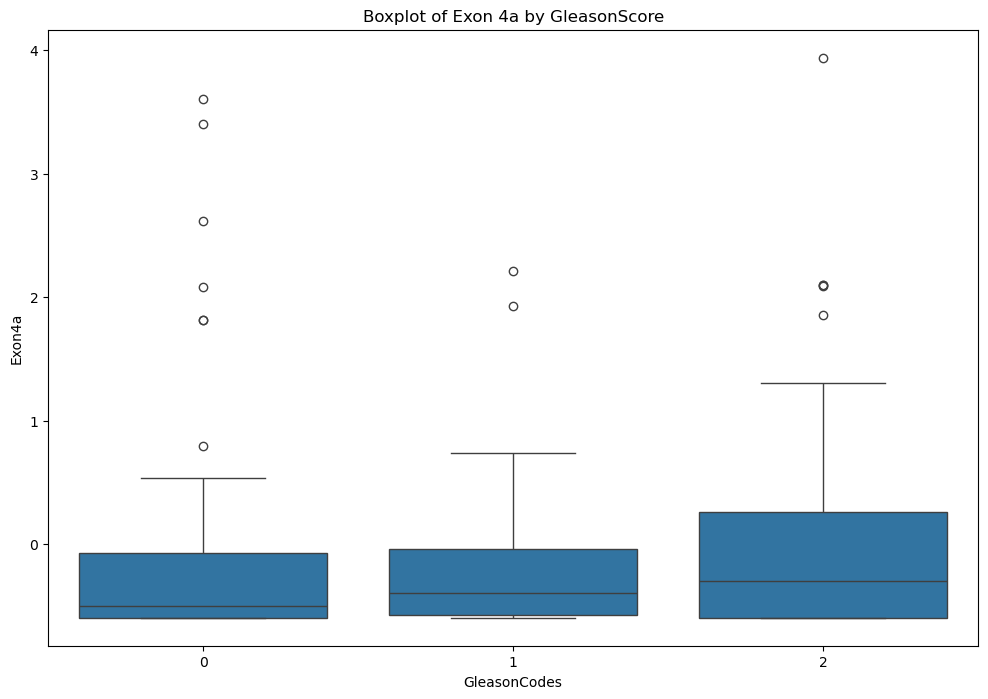

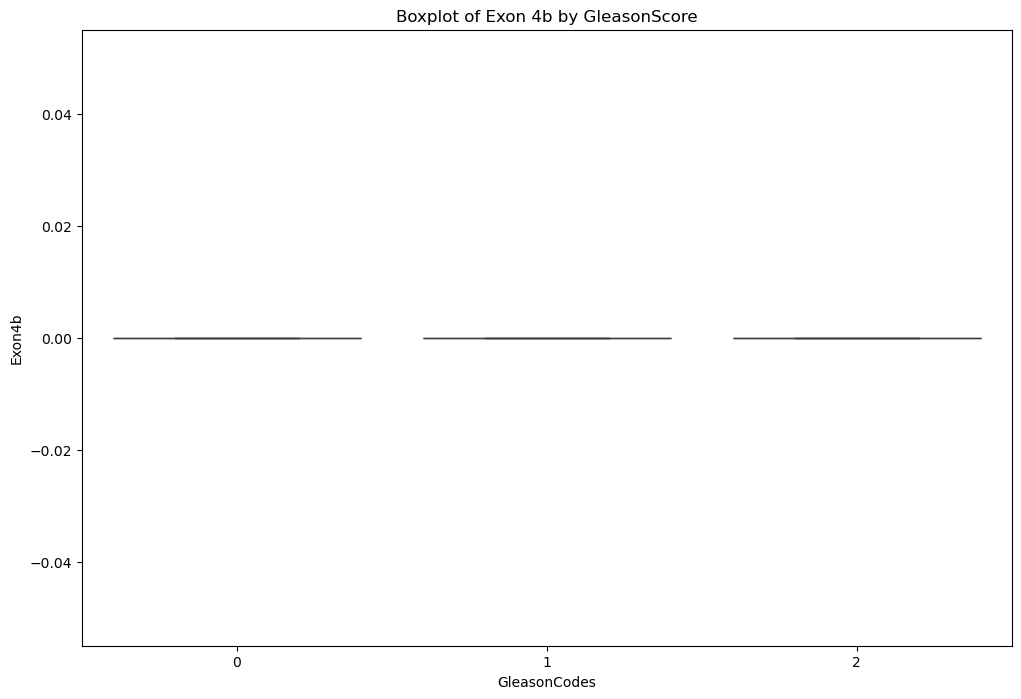

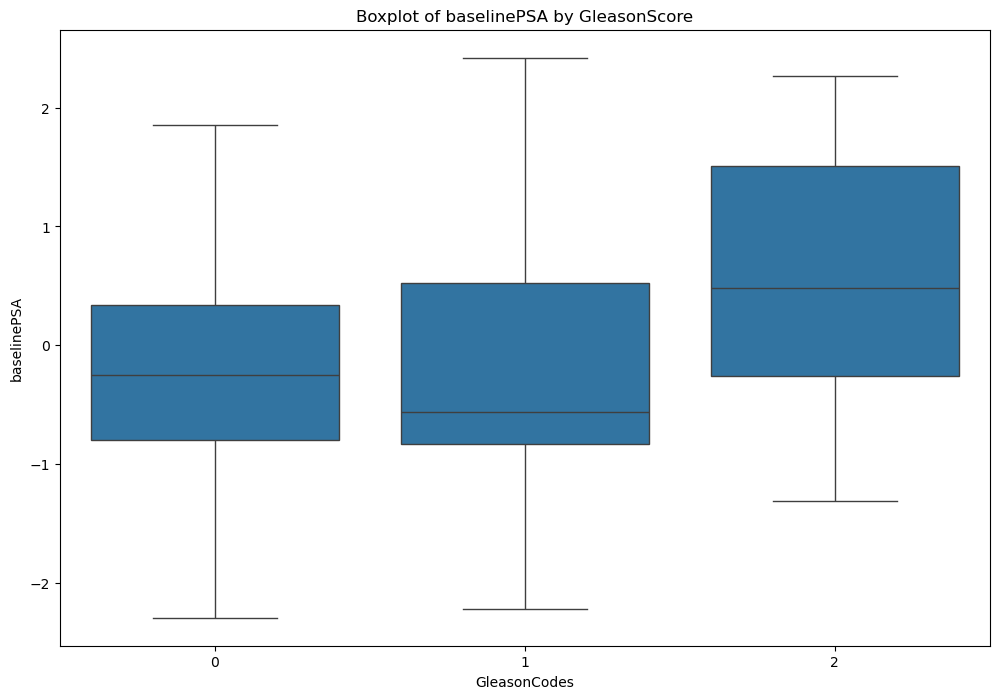

In [477]:
# Part 1: Boxplots of each predictor variable 
plt.figure(figsize=(12, 8))
sns.boxplot(x='GleasonCodes', y='Exon9', data=data)
plt.title("Boxplot of Exon 9 by GleasonScore")
plt.show()

plt.figure(figsize=(12, 8))
sns.boxplot(x='GleasonCodes', y='Exon4a', data=data)
plt.title("Boxplot of Exon 4a by GleasonScore")
plt.show()

plt.figure(figsize=(12, 8))
sns.boxplot(x='GleasonCodes', y='Exon4b', data=data)
plt.title("Boxplot of Exon 4b by GleasonScore")
plt.show()

plt.figure(figsize=(12, 8))
sns.boxplot(x='GleasonCodes', y='baselinePSA', data=data)
plt.title("Boxplot of baselinePSA by GleasonScore")
plt.show()

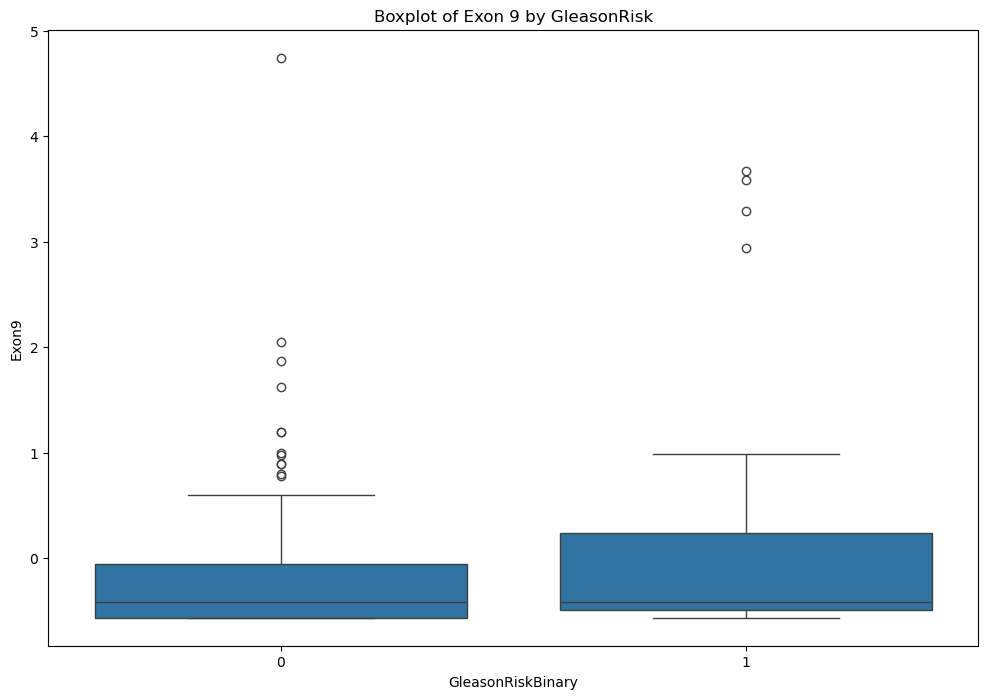

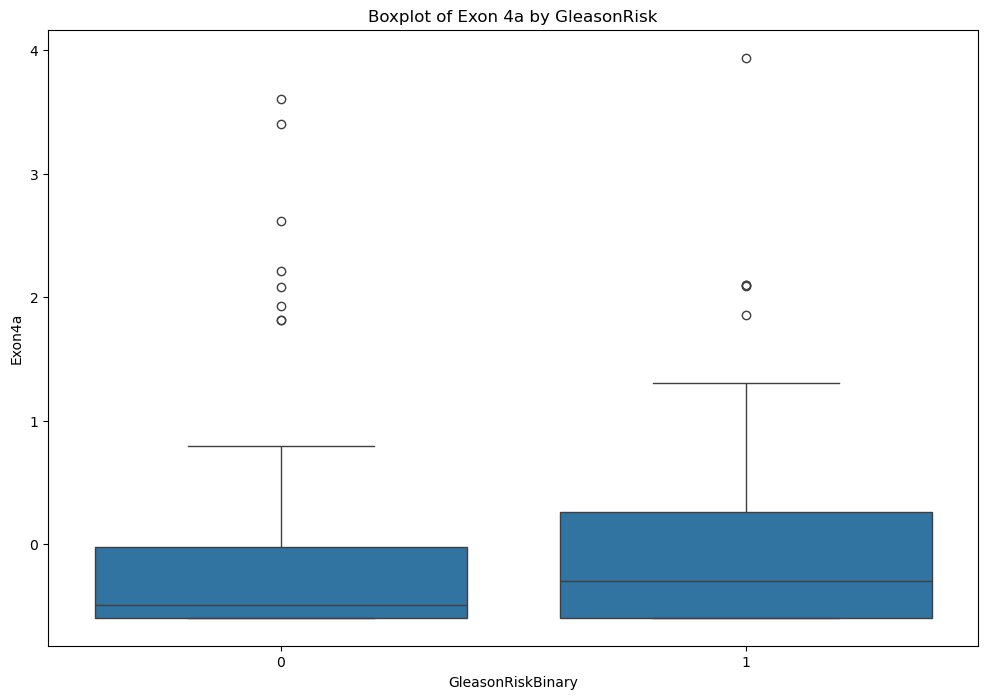

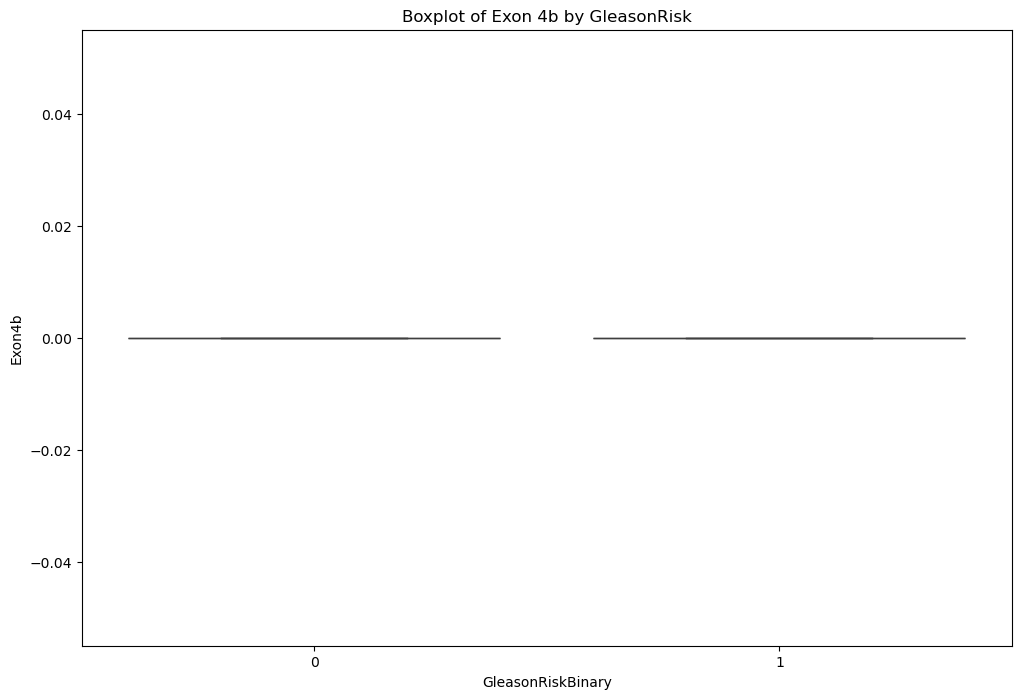

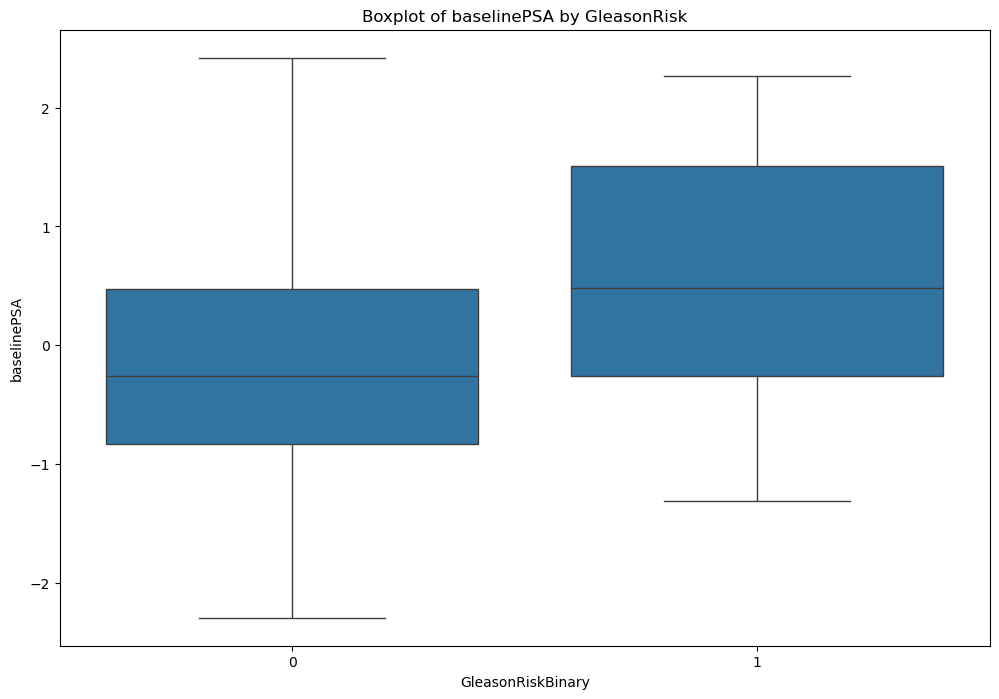

In [478]:
# Boxplots with GleasonRisk
plt.figure(figsize=(12, 8))
sns.boxplot(x='GleasonRiskBinary', y='Exon9', data=data)
plt.title("Boxplot of Exon 9 by GleasonRisk")
plt.show()

plt.figure(figsize=(12, 8))
sns.boxplot(x='GleasonRiskBinary', y='Exon4a', data=data)
plt.title("Boxplot of Exon 4a by GleasonRisk")
plt.show()

plt.figure(figsize=(12, 8))
sns.boxplot(x='GleasonRiskBinary', y='Exon4b', data=data)
plt.title("Boxplot of Exon 4b by GleasonRisk")
plt.show()

plt.figure(figsize=(12, 8))
sns.boxplot(x='GleasonRiskBinary', y='baselinePSA', data=data)
plt.title("Boxplot of baselinePSA by GleasonRisk")
plt.show()

## Single Logistic Regression 

In [479]:
# Logistic regression for Exon 9
model_gleason_exon9 = Logit(data['GleasonRiskBinary'].cat.codes, data[['Exon9']]).fit()
print(model_gleason_exon9.summary())


Optimization terminated successfully.
         Current function value: 0.684146
         Iterations 5
                           Logit Regression Results                           
Dep. Variable:                      y   No. Observations:                  108
Model:                          Logit   Df Residuals:                      107
Method:                           MLE   Df Model:                            0
Date:                Mon, 21 Oct 2024   Pseudo R-squ.:                 -0.1579
Time:                        17:49:16   Log-Likelihood:                -73.888
converged:                       True   LL-Null:                       -63.811
Covariance Type:            nonrobust   LLR p-value:                       nan
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Exon9          0.2809      0.211      1.334      0.182      -0.132       0.694


In [480]:
# Logistic regression for Exon 4a
model_gleason_exon4a = Logit(data['GleasonRiskBinary'].cat.codes, data[['Exon4a']]).fit()
print(model_gleason_exon4a.summary())


Optimization terminated successfully.
         Current function value: 0.687301
         Iterations 4
                           Logit Regression Results                           
Dep. Variable:                      y   No. Observations:                  108
Model:                          Logit   Df Residuals:                      107
Method:                           MLE   Df Model:                            0
Date:                Mon, 21 Oct 2024   Pseudo R-squ.:                 -0.1633
Time:                        17:49:16   Log-Likelihood:                -74.229
converged:                       True   LL-Null:                       -63.811
Covariance Type:            nonrobust   LLR p-value:                       nan
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Exon4a         0.2207      0.200      1.102      0.271      -0.172       0.613


In [481]:
# Logistic regression for baseline PSA
model_gleason_psa = Logit(data['GleasonRiskBinary'].cat.codes, data[['baselinePSA']]).fit()
print(model_gleason_psa.summary())

Optimization terminated successfully.
         Current function value: 0.652366
         Iterations 5
                           Logit Regression Results                           
Dep. Variable:                      y   No. Observations:                  108
Model:                          Logit   Df Residuals:                      107
Method:                           MLE   Df Model:                            0
Date:                Mon, 21 Oct 2024   Pseudo R-squ.:                 -0.1041
Time:                        17:49:16   Log-Likelihood:                -70.456
converged:                       True   LL-Null:                       -63.811
Covariance Type:            nonrobust   LLR p-value:                       nan
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
baselinePSA     0.6036      0.215      2.813      0.005       0.183       1.024


## Multiple Logistic regression models with baselinePSA included in all combinations


In [482]:
model_psa_exon9 = Logit(data['GleasonRiskBinary'].cat.codes, data[['baselinePSA', 'Exon9']]).fit()
print(model_psa_exon9.summary())

Optimization terminated successfully.
         Current function value: 0.642231
         Iterations 5
                           Logit Regression Results                           
Dep. Variable:                      y   No. Observations:                  108
Model:                          Logit   Df Residuals:                      106
Method:                           MLE   Df Model:                            1
Date:                Mon, 21 Oct 2024   Pseudo R-squ.:                -0.08698
Time:                        17:49:16   Log-Likelihood:                -69.361
converged:                       True   LL-Null:                       -63.811
Covariance Type:            nonrobust   LLR p-value:                     1.000
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
baselinePSA     0.6139      0.215      2.853      0.004       0.192       1.036
Exon9           0.3051    

In [483]:
model_psa_exon4a = Logit(data['GleasonRiskBinary'].cat.codes, data[['baselinePSA', 'Exon4a']]).fit()
print(model_psa_exon4a.summary())

Optimization terminated successfully.
         Current function value: 0.646600
         Iterations 5
                           Logit Regression Results                           
Dep. Variable:                      y   No. Observations:                  108
Model:                          Logit   Df Residuals:                      106
Method:                           MLE   Df Model:                            1
Date:                Mon, 21 Oct 2024   Pseudo R-squ.:                -0.09437
Time:                        17:49:16   Log-Likelihood:                -69.833
converged:                       True   LL-Null:                       -63.811
Covariance Type:            nonrobust   LLR p-value:                     1.000
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
baselinePSA     0.6043      0.215      2.812      0.005       0.183       1.025
Exon4a          0.2265    

In [484]:
model_psa_exon9_exon4a = Logit(data['GleasonRiskBinary'].cat.codes, data[['baselinePSA', 'Exon9', 'Exon4a']]).fit()
print(model_psa_exon9_exon4a.summary())

Optimization terminated successfully.
         Current function value: 0.641888
         Iterations 5
                           Logit Regression Results                           
Dep. Variable:                      y   No. Observations:                  108
Model:                          Logit   Df Residuals:                      105
Method:                           MLE   Df Model:                            2
Date:                Mon, 21 Oct 2024   Pseudo R-squ.:                -0.08640
Time:                        17:49:16   Log-Likelihood:                -69.324
converged:                       True   LL-Null:                       -63.811
Covariance Type:            nonrobust   LLR p-value:                     1.000
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
baselinePSA     0.6124      0.215      2.845      0.004       0.191       1.034
Exon9           0.2618    

## Likelihood Ratio Test

In [485]:
# Extract log-likelihoods
logL_psa = model_psa.llf
logL_psa_exon9 = model_psa_exon9.llf
logL_psa_exon4a = model_psa_exon4a.llf
logL_psa_exon9_exon4a = model_psa_exon9_exon4a.llf

# Perform likelihood ratio tests
# 1. Compare baseline model vs. PSA + Exon 9
LRT_psa_vs_psa_exon9 = 2 * (logL_psa_exon9 - logL_psa)
df1 = model_psa_exon9.df_model - model_psa.df_model
p_value_psa_vs_psa_exon9 = stats.chi2.sf(LRT_psa_vs_psa_exon9, df1)

# 2. Compare baseline model vs. PSA + Exon 4a
LRT_psa_vs_psa_exon4a = 2 * (logL_psa_exon4a - logL_psa)
df2 = model_psa_exon4a.df_model - model_psa.df_model
p_value_psa_vs_psa_exon4a = stats.chi2.sf(LRT_psa_vs_psa_exon4a, df2)

# 3. Compare PSA + Exon 9 vs. PSA + Exon 9 + Exon 4a
LRT_psa_exon9_vs_psa_exon9_exon4a = 2 * (logL_psa_exon9_exon4a - logL_psa_exon9)
df3 = model_psa_exon9_exon4a.df_model - model_psa_exon9.df_model
p_value_psa_exon9_vs_psa_exon9_exon4a = stats.chi2.sf(LRT_psa_exon9_vs_psa_exon9_exon4a, df3)

# 4. Compare PSA + Exon 4a vs. PSA + Exon 9 + Exon 4a
LRT_psa_exon4a_vs_psa_exon9_exon4a = 2 * (logL_psa_exon9_exon4a - logL_psa_exon4a)
df4 = model_psa_exon9_exon4a.df_model - model_psa_exon4a.df_model
p_value_psa_exon4a_vs_psa_exon9_exon4a = stats.chi2.sf(LRT_psa_exon4a_vs_psa_exon9_exon4a, df4)

# Print p-values
print("P-value (PSA vs PSA + Exon 9):", p_value_psa_vs_psa_exon9)
print("P-value (PSA vs PSA + Exon 4a):", p_value_psa_vs_psa_exon4a)
print("P-value (PSA + Exon 9 vs PSA + Exon 9 + Exon 4a):", p_value_psa_exon9_vs_psa_exon9_exon4a)
print("P-value (PSA + Exon 4a vs PSA + Exon 9 + Exon 4a):", p_value_psa_exon4a_vs_psa_exon9_exon4a)

P-value (PSA vs PSA + Exon 9): nan
P-value (PSA vs PSA + Exon 4a): nan
P-value (PSA + Exon 9 vs PSA + Exon 9 + Exon 4a): 0.7855155249441059
P-value (PSA + Exon 4a vs PSA + Exon 9 + Exon 4a): 0.3130727749664991


## Model Comparison (AIC) and Evaluation


## 10 fold cross validation, Likelihood Ratio, and AUC

In [486]:
# Model 1: baselinePSA + Exon 9
X1 = data[['baselinePSA', 'Exon9']]
y = data['GleasonRiskBinary']

# Train logistic regression on the full dataset for likelihood comparison
log_reg1 = LogisticRegression()
log_reg1.fit(X1, y)

# Get cross-validated predictions
y_pred_model_psa_exon9 = cross_val_predict(log_reg1, X1, y, cv=kf)

# Calculate metrics
acc1, prec1, rec1, sens1, spec1 = calculate_metrics(y, y_pred_model_psa_exon9)
print(f"Model PSA + Exon 9: Accuracy={acc1:.3f}, Precision={prec1:.3f}, Recall={rec1:.3f}, Sensitivity={sens1:.3f}, Specificity={spec1:.3f}")

# Calculate log-likelihood for Model 1
ll_full1 = np.sum(np.log(np.maximum(1e-10, log_reg1.predict_proba(X1)[:, 1])))  # Likelihood for the model


Model PSA + Exon 9: Accuracy=0.704, Precision=0.400, Recall=0.133, Sensitivity=0.133, Specificity=0.923


AUC for Model PSA + Exon 9: 0.718


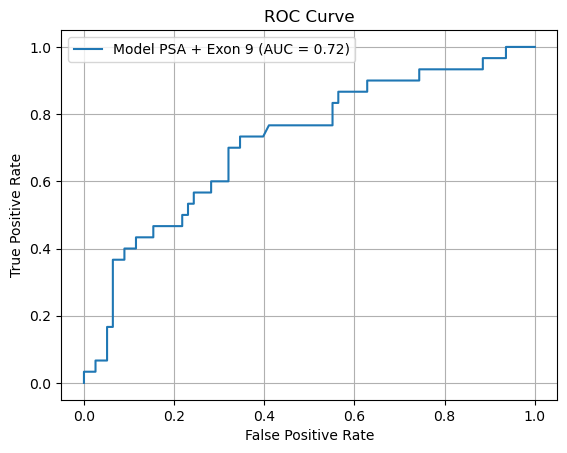

In [487]:
# Calculate AUC for Model 1
y_pred_proba_model1 = log_reg1.predict_proba(X1)[:, 1]
auc_model1 = roc_auc_score(y, y_pred_proba_model1)
print(f"AUC for Model PSA + Exon 9: {auc_model1:.3f}")

# If you want to plot the ROC curve
fpr, tpr, thresholds = roc_curve(y, y_pred_proba_model1)
plt.plot(fpr, tpr, label=f'Model PSA + Exon 9 (AUC = {auc_model1:.2f})')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.grid()
plt.show()

In [488]:
# Model 2: baselinePSA + Exon 4a
X2 = data[['baselinePSA', 'Exon4a']]
y = data['GleasonRiskBinary']

# Train logistic regression on the full dataset for likelihood comparison
log_reg2 = LogisticRegression()
log_reg2.fit(X2, y)

# Get cross-validated predictions
y_pred_model_psa_exon9_exon4a = cross_val_predict(log_reg2, X2, y, cv=kf)

# Calculate metrics
acc2, prec2, rec2, sens2, spec2 = calculate_metrics(y, y_pred_model_psa_exon9_exon4a)
print(f"Model PSA + Exon 9 + Exon 4a: Accuracy={acc2:.3f}, Precision={prec2:.3f}, Recall={rec2:.3f}, Sensitivity={sens2:.3f}, Specificity={spec2:.3f}")

# Calculate log-likelihood for Model 2
ll_full2 = np.sum(np.log(np.maximum(1e-10, log_reg2.predict_proba(X2)[:, 1])))

Model PSA + Exon 9 + Exon 4a: Accuracy=0.704, Precision=0.375, Recall=0.100, Sensitivity=0.100, Specificity=0.936


AUC for Model PSA + Exon 4a: 0.716


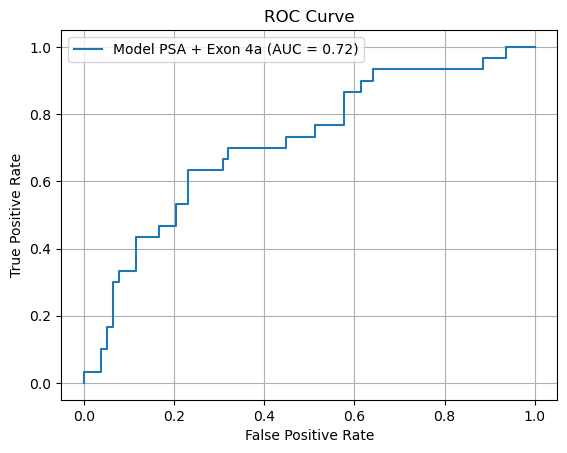

In [489]:
# Calculate AUC for Model 2
y_pred_proba_model2 = log_reg2.predict_proba(X2)[:, 1]
auc_model2 = roc_auc_score(y, y_pred_proba_model2)
print(f"AUC for Model PSA + Exon 4a: {auc_model2:.3f}")

# If you want to plot the ROC curve
fpr, tpr, thresholds = roc_curve(y, y_pred_proba_model2)
plt.plot(fpr, tpr, label=f'Model PSA + Exon 4a (AUC = {auc_model2:.2f})')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.grid()
plt.show()

In [490]:
# Model 3: baselinePSA + Exon 4a
X3 = data[['baselinePSA', 'Exon9', 'Exon4a']]
y = data['GleasonRiskBinary']


# Train logistic regression on the full dataset for likelihood comparison
log_reg3 = LogisticRegression(max_iter=1000)
log_reg3.fit(X3, y)

# Get cross-validated predictions
y_pred_model_psa_exon4a = cross_val_predict(log_reg3, X3, y, cv=kf)

# Calculate metrics
acc3, prec3, rec3, sens3, spec3 = calculate_metrics(y, y_pred_model_psa_exon4a)
print(f"Model PSA + Exon 4a: Accuracy={acc3:.3f}, Precision={prec3:.3f}, Recall={rec3:.3f}, Sensitivity={sens3:.3f}, Specificity={spec3:.3f}")

# Calculate log-likelihood for Model 3
ll_full3 = np.sum(np.log(np.maximum(1e-10, log_reg3.predict_proba(X3)[:, 1])))

Model PSA + Exon 4a: Accuracy=0.685, Precision=0.333, Recall=0.133, Sensitivity=0.133, Specificity=0.897


AUC for Model PSA + Exon 9 + Exon 4a: 0.725


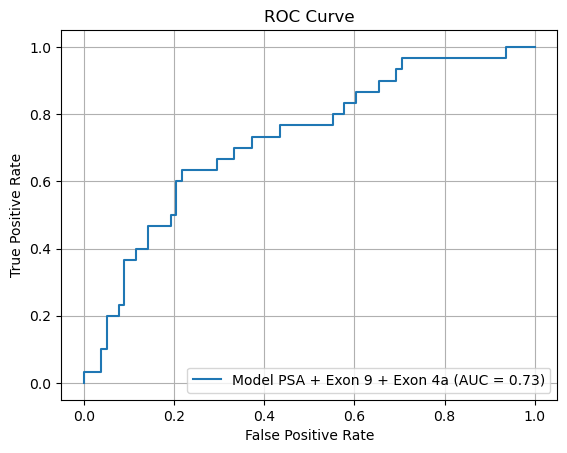

In [491]:
# Calculate AUC for Model 3
y_pred_proba_model3 = log_reg3.predict_proba(X3)[:, 1]
auc_model3 = roc_auc_score(y, y_pred_proba_model3)
print(f"AUC for Model PSA + Exon 9 + Exon 4a: {auc_model3:.3f}")

# If you want to plot the ROC curve
fpr, tpr, thresholds = roc_curve(y, y_pred_proba_model3)
plt.plot(fpr, tpr, label=f'Model PSA + Exon 9 + Exon 4a (AUC = {auc_model3:.2f})')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.grid()
plt.show()

In [492]:
# Model 4: baselinePSA only
X4 = data[['baselinePSA']]
y = data['GleasonRiskBinary']


# Train logistic regression on the full dataset for likelihood comparison
log_reg4 = LogisticRegression(max_iter=1000)
log_reg4.fit(X4, y)

# Get cross-validated predictions
y_pred_model_psa = cross_val_predict(log_reg4, X4, y, cv=kf)

# Calculate metrics
acc4, prec4, rec4, sens4, spec4 = calculate_metrics(y, y_pred_model_psa)
print(f"Model PSA Only: Accuracy={acc4:.3f}, Precision={prec4:.3f}, Recall={rec4:.3f}, Sensitivity={sens4:.3f}, Specificity={spec4:.3f}")

# Calculate log-likelihood for Model 4
ll_full4 = np.sum(np.log(np.maximum(1e-10, log_reg4.predict_proba(X4)[:, 1])))

Model PSA Only: Accuracy=0.750, Precision=0.667, Recall=0.200, Sensitivity=0.200, Specificity=0.962


AUC for Model PSA Only: 0.690


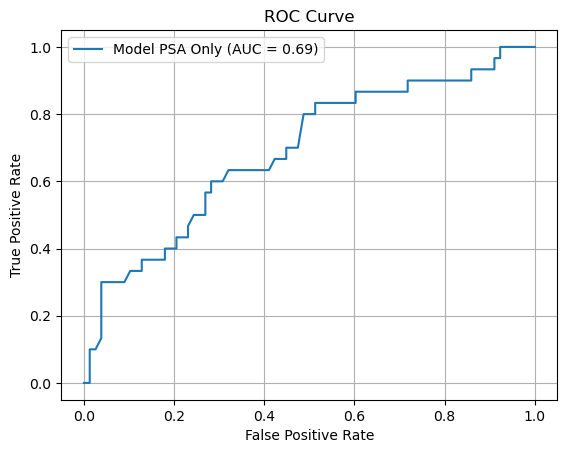

In [493]:
# Calculate AUC for Model 4
y_pred_proba_model4 = log_reg4.predict_proba(X4)[:, 1]
auc_model4 = roc_auc_score(y, y_pred_proba_model4)
print(f"AUC for Model PSA Only: {auc_model4:.3f}")

# If you want to plot the ROC curve
fpr, tpr, thresholds = roc_curve(y, y_pred_proba_model4)
plt.plot(fpr, tpr, label=f'Model PSA Only (AUC = {auc_model4:.2f})')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.grid()
plt.show()

## Likelihood Ratio Test

In [494]:
# Perform Likelihood Ratio Tests between models
def likelihood_ratio_test(ll_full, ll_reduced, df_full, df_reduced):
    lr_stat = 2 * (ll_full - ll_reduced)
    df_diff = df_full - df_reduced
    p_value = stats.chi2.sf(lr_stat, df_diff)
    return lr_stat, p_value

# LRT: Model 3 (PSA + Exon 9 + Exon 4a) vs Model 1 (PSA + Exon 9)
lr_stat_12, p_value_12 = likelihood_ratio_test(ll_full2, ll_full1, X2.shape[1], X1.shape[1])
print(f"LRT for Model PSA + Exon 9 + Exon 4a vs PSA + Exon 9: LR Stat={lr_stat_12:.3f}, p-value={p_value_12:.3f}")

# LRT: Model 2 (PSA + Exon 4a) vs Model 4 (PSA only)
lr_stat_34, p_value_34 = likelihood_ratio_test(ll_full3, ll_full4, X3.shape[1], X4.shape[1])
print(f"LRT for Model PSA + Exon 4a vs PSA Only: LR Stat={lr_stat_34:.3f}, p-value={p_value_34:.3f}")

# LRT: Model 3 (PSA + Exon 9 + Exon 4a) vs Model 2 (PSA + Exon 4a)
lr_stat_23, p_value_23 = likelihood_ratio_test(ll_full2, ll_full3, X2.shape[1], X3.shape[1])
print(f"LRT for Model PSA + Exon 9 + Exon 4a vs PSA + Exon 4a: LR Stat={lr_stat_23:.3f}, p-value={p_value_23:.3f}")

# LRT: Model 1 (PSA + Exon 9) vs Model 4 (PSA only)
lr_stat_14, p_value_14 = likelihood_ratio_test(ll_full1, ll_full4, X1.shape[1], X4.shape[1])
print(f"LRT for Model PSA + Exon 9 vs PSA Only: LR Stat={lr_stat_14:.3f}, p-value={p_value_14:.3f}")

LRT for Model PSA + Exon 9 + Exon 4a vs PSA + Exon 9: LR Stat=1.904, p-value=nan
LRT for Model PSA + Exon 4a vs PSA Only: LR Stat=-7.676, p-value=1.000
LRT for Model PSA + Exon 9 + Exon 4a vs PSA + Exon 4a: LR Stat=2.897, p-value=nan
LRT for Model PSA + Exon 9 vs PSA Only: LR Stat=-6.683, p-value=1.000
